# iNERF test

In [1]:
import torch
import torch.nn as nn
from models.vanilla_nerf.model import NeRF
from PIL import Image
from pathlib import  Path as P
import json
import torchvision.transforms as transforms
import numpy as np
from datasets.ray_utils import get_ray_directions
import matplotlib.pyplot as plt
from models.vanilla_nerf.model_nerfseg import  get_rays_torch
from models.vanilla_nerf.helper import img2mse
# from pytorch3d.transforms import quaternion_to_matrix
import torch.nn.functional as F
from utils.viewpoint import pose2view_torch, view2pose_torch, change_apply_change_basis_torch


## Helper functions

In [2]:
def load_json(json_fname):
    with open(json_fname, 'r') as json_file:
        data_dict = json.load(json_file)
    return data_dict

def remove_model_prefix(input_dict):
    """
    Remove the "model." prefix from all key names in a dictionary.

    Args:
        input_dict (dict): The input dictionary.

    Returns:
        dict: A new dictionary with the "model." prefix removed from key names.
    """
    output_dict = {}
    for key, value in input_dict.items():
        # Check if the key starts with "model."
        if key.startswith("model."):
            # Remove the "model." prefix and add to the new dictionary
            new_key = key[len("model."):]
            output_dict[new_key] = value
        else:
            # If the key doesn't start with "model.", add it as is
            output_dict[key] = value
    return output_dict

def load_model_with_check(model, state_dict_dict):
    """
    Load a PyTorch model's state_dict from a dictionary and report missing
    and unexpected keys.

    Args:
        model (torch.nn.Module): The model to which the state_dict should be loaded.
        state_dict_dict (dict): The state_dict dictionary.

    Returns:
        model (torch.nn.Module): The model with the loaded state_dict.
        missing_keys (list): List of keys that were in the state_dict but not in the model.
        unexpected_keys (list): List of keys that were in the model but not in the state_dict.
    """
    # Load the state_dict
    state_dict = state_dict_dict

    # Load the model's state_dict and track missing and unexpected keys
    missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)

    # Report missing and unexpected keys
    if missing_keys:
        print("Missing keys in the model's state_dict:")
        for key in missing_keys:
            print(key)
    if unexpected_keys:
        print("Unexpected keys found in the model's state_dict:")
        for key in unexpected_keys:
            print(key)

    return model, missing_keys, unexpected_keys

def select_fg(value, seg):
    # Squeeze the seg tensor to remove the singleton dimension
    seg = seg.squeeze(dim=1)
    
    # Create a mask for the selected segments
    mask = (seg > 0)

    # Apply the mask to the value tensor to select the desired elements
    selected_value = value[mask]

    return selected_value

def select_element(value, seg, part_num=0):
    # Squeeze the seg tensor to remove the singleton dimension
    seg = seg.squeeze(dim=1)
    
    # Create a mask for the selected segments
    mask = (seg == part_num)

    # Apply the mask to the value tensor to select the desired elements
    selected_value = value[mask]

    return selected_value

def select_element_inv(value, seg, part_num=0):
    '''
    select the element except the part_num
    '''
    # Squeeze the seg tensor to remove the singleton dimension
    seg = seg.squeeze(dim=1)
    
    # Create a mask for the selected segments
    mask = ~(seg == part_num)

    # Apply the mask to the value tensor to select the desired elements
    selected_value = value[mask]

    return selected_value

def overlay_images(image_A, image_B, transparency):
    """
    Overlay two images with adjustable transparency.

    Args:
    - image_A (PIL Image): The base image.
    - image_B (PIL Image): The overlay image.
    - transparency (float): The transparency level (0.0 to 1.0, where 0.0 is fully transparent, and 1.0 is fully opaque).

    Returns:
    - PIL Image: The overlayed image.
    """
    # Ensure that both images have the same size
    if image_A.size != image_B.size:
        raise ValueError("Both input images must have the same size")

    # Convert the transparency value to an alpha value (0 to 255)
    alpha = int(255 * (1 - transparency))

    # Create copies of the images to avoid modifying the originals
    base_image = image_A.copy()
    overlay_image = image_B.copy()

    # Apply the transparency to the overlay image
    overlay_image.putalpha(alpha)

    # Paste the overlay image onto the base image
    base_image.paste(overlay_image, (0, 0), overlay_image)

    return base_image

def render_img(model, directions, c2w, chunk_size=4096):
    randomized = False
    white_bkgd = True
    far=6
    near=2
    chunk_size = 1024 * 3
    # get rays_o, rays_d, view_dir 
    rays_o, viewdirs, rays_d = get_rays_torch(directions, c2w[:3, :], output_view_dirs=True)
    chunk_len = rays_o.shape[0] // chunk_size + 1
    chunk_idxs = torch.arange(0, chunk_len) * chunk_size
    chunk_idxs[-1] = rays_o.shape[0]
    ret_list = []
    with torch.no_grad():
        for i in range(len(chunk_idxs) - 1):
            mini_batch = {}
            begin, end = chunk_idxs[i], chunk_idxs[i+1]
            mini_batch['rays_o'] = rays_o[begin: end]
            mini_batch['rays_d'] = rays_d[begin: end]
            mini_batch['viewdirs'] = viewdirs[begin: end]
            mini_ret = model.forward(mini_batch, randomized, white_bkgd, near, far)

            ret_list += [mini_ret[1][0].detach().cpu()]
    ret_rgb = torch.cat(ret_list, dim=0)
    return ret_rgb

def save_images_as_gif(imgs, interval, save_path):
    """
    Save a list of numpy arrays as a GIF file.

    Args:
    - imgs (list of numpy arrays): List of images to be saved as frames in the GIF.
    - interval (int): Time interval between frames in milliseconds.
    - save_path (str): Filepath where the GIF should be saved.

    Returns:
    - None
    """
    # Ensure the save_path ends with '.gif'
    if not save_path.endswith('.gif'):
        save_path += '.gif'

    # Convert numpy arrays to PIL images
    pil_imgs = [Image.fromarray(np.uint8(img*255)) for img in imgs]

    # Save the images as a GIF
    pil_imgs[0].save(save_path, save_all=True, append_images=pil_imgs[1:], duration=interval, loop=0)
    return pil_imgs


def R_from_quaternions(quaternions: torch.tensor):
    quaternions = F.normalize(quaternions, p=2., dim=0)

    r, i, j, k = torch.unbind(quaternions, -1)
    two_s = 2.0 / (quaternions * quaternions).sum(-1)

    o = torch.stack(
        (
            1 - two_s * (j * j + k * k),
            two_s * (i * j - k * r),
            two_s * (i * k + j * r),
            two_s * (i * j + k * r),
            1 - two_s * (i * i + k * k),
            two_s * (j * k - i * r),
            two_s * (i * k - j * r),
            two_s * (j * k + i * r),
            1 - two_s * (i * i + j * j),
        ),
        -1,
    )
    return o.reshape(quaternions.shape[:-1] + (3, 3)).to(quaternions)

## Load data for optimization

In [3]:
root_path = P("./data/laptop_art_same_pose/train/idx_5/")
# root_path = P("./data/laptop_10211/test/")
device = 'cuda'
transform_meta = load_json(str(root_path / 'transforms.json'))
frame_id = 'r_6'
# pose_np = np.array(transform_meta['frames']['r_3'])
w, h = 640, 480

def fetch_img(root_path, transform_meta, w=640, h=480, device='cuda', if_fix=True):
    if if_fix:
        idx = 5
    else:
        idx = np.random.randint(0, 9)
    frame_id = 'r_' + str(idx)
    pose_np = np.array(transform_meta['frame'][frame_id])

    rgb_pil = Image.open(str(root_path/'rgb'/(frame_id + '.png')))
    rgb = transforms.ToTensor()(rgb_pil).to(device)
    rgb = rgb.view(4, -1).permute(1, 0) # (H*W, 4) RGBA
    rgb = rgb[:, :3]*rgb[:, -1:] + (1-rgb[:, -1:]) # blend A to RGB

    pose = torch.Tensor(pose_np).to(device)

    seg_pil = Image.open(str(root_path/'seg'/(frame_id + '.png')))
    seg_np = np.array(seg_pil)
    seg = torch.Tensor(seg_np).to(device).view([1, -1]).permute(1, 0)
    seg = seg.type(torch.LongTensor)
    seg = seg - 1 # starts with 2
    seg[seg<0] = 0
    focal = transform_meta['focal']
    directions = get_ray_directions(h, w, focal).view([-1, 3])
    ret_dict = {
        'rgb': rgb,
        'seg': seg,
        'directions': directions,
        'pose': pose
    }
    return ret_dict

def fetch_img_draft():
    img_art = './draft/test_view_15.png'
    pose_file = './draft/inerf_pose.json'
    with open(pose_file, 'r') as f:
        pose = json.load(f)
    focal = 761.1827392578125
    w=640
    h=480
    device = 'cuda'
    directions = get_ray_directions(h, w, focal).view([-1, 3]).to(device)
    origin_pose = torch.Tensor(np.array(pose['view_0'])).to(device)
    target_pose = torch.Tensor(np.array(pose['view_1'])).to(device)
    rgb_pil = Image.open(img_art)
    rgb = transforms.ToTensor()(rgb_pil).to(device)
    rgb = rgb.view(4, -1).permute(1, 0) # (H*W, 4) RGBA
    rgb = rgb[:, :3]*rgb[:, -1:] + (1-rgb[:, -1:]) # blend A to RGB

    seg_pil = Image.open('./draft/test_view_15_seg.png')
    seg_np = np.array(seg_pil)
    seg = torch.Tensor(seg_np).to(device).view([1, -1]).permute(1, 0)
    seg = seg.type(torch.LongTensor)
    seg = seg - 1 # starts with 2
    seg[seg<0] = 0


    ret_dict = {
        'pose': origin_pose,
        'directions': directions.to(dtype=torch.float),
        'rgb': rgb.to(device),
        'target_pose': target_pose,
        'seg': seg.to(device)
    }
    return ret_dict

## NeRF model setup

In [4]:
# load ckpt state_dict
ckpt_file = "results/laptop/nerf_laptop/last.ckpt"
ckpt_dict_model = torch.load(ckpt_file)['state_dict']
ckpt_dict = remove_model_prefix(ckpt_dict_model)
# initialize model and load pre-trained weights
model = NeRF()
model, _, _ = load_model_with_check(model, ckpt_dict)
model = model.to(device)

## Add view transform variable

In [5]:
from utils.rotation import *
from utils.viewpoint import *
class ViewTransform(nn.Module):
    def __init__(self, mode='Q'):
        super().__init__()
        if mode == 'Q':
            self.initialize_param = torch.Tensor([
                1, 0, 0, 0
            ]) # [Q, T]
        else:
            self.initialize_param = torch.Tensor([
                [1, 0, 0, 0], 
                [0, 1, 0, 0],
                [0, 0, 1, 0]
            ]).view([-1])
        self.mode = mode
        self.weight = nn.Parameter(self.initialize_param, requires_grad = True)

    def forward(self, input):
        """
        input: 4x4 c2w matrix
        """
        constant = torch.Tensor([
            [0, 0, 0, 1]
        ]).to(dtype=self.weight.dtype, device=self.weight.device)
        if self.mode == 'Q':
            Q = self.weight[:4]
            # print(Q)
            T = torch.zeros([3,1]).to(self.weight)
            norm_Q = Q / torch.linalg.norm(Q.clone(), ord=2)
            rot = R_from_quaternions(norm_Q)
            m34 = torch.cat((rot, T), dim=1)
            weight = torch.cat((m34, constant), dim=0)
        else:
            weight = torch.cat((self.weight.view([3, 4]), constant), dim=0)
            # print(weight)
        new_view_point = torch.matmul(input, weight)
        return new_view_point
    
    def reset(self):
        initialize_param = torch.Tensor([
            [1, 0, 0, 0], 
            [0, 1, 0, 0],
            [0, 0, 1, 0]
        ]).view([-1])
        device = self.weight.device
        self.weight = nn.Parameter(initialize_param, requires_grad = True).to(device)


class ArticulationEstimation(nn.Module):
    '''
    Current implemetation for revolute only
    '''
    def __init__(self, mode='qua') -> None:
        super().__init__()
        if mode == 'qua':
            pass
        elif mode == 'rad': #radian
            pass
        elif mode == 'deg': # degree
            pass
        else:
            raise RuntimeError('mode == %s for ArticulationEstimation is not defined' % mode)
        
        # perfect init
        # init_Q = torch.Tensor([ 0.9962,  0.0000, -0.0872,  0.0000])
        # axis_origin = torch.Tensor([ 0.24714715,  0.        , -0.00770604])
        # normal init
        init_Q = torch.Tensor([1, 0, 0, 0])
        axis_origin = torch.Tensor([ 0, 0, 0])

        # axis angle can be obtained from quaternion
        # axis_direction = torch.Tensor([0, 0, 0])

        self.Q = nn.Parameter(init_Q, requires_grad = True)
        self.axis_origin = nn.Parameter(axis_origin, requires_grad = True)
        # self.axis_direction = nn.Parameter(axis_direction, requires_grad = True)


    def forward(self, c2w) -> torch.Tensor():
        '''
        input: c2w
        '''
        E1 = view2pose_torch(c2w)
        translation_matrix = torch.eye(4).to(c2w)
        translation_matrix[:3, 3] = self.axis_origin.view([3])
        rotation_matrix = torch.eye(4).to(c2w)
        R = R_from_quaternions(self.Q)
        rotation_matrix[:3, :3] = R
        E2 = change_apply_change_basis_torch(E1, rotation_matrix, translation_matrix)
        view = pose2view_torch(E2)
        return view
        

view_deform = ViewTransform(mode='M').to(device)
art_est = ArticulationEstimation().to(device)

## Forward function

In [6]:
data_dict = fetch_img(root_path, transform_meta)

directions = data_dict['directions']
rgb = data_dict['rgb']
seg = data_dict['seg']
pose = data_dict['pose']

directions = directions.to(device)
part_num = 2

# selected_dirs = select_element_inv(directions, seg, part_num=part_num).to(device)
# selected_rgbs = select_element_inv(rgb, seg, part_num=part_num).to(device)

# selected_dirs = select_element(directions, seg, part_num=part_num).to(device)
# selected_rgbs = select_element(rgb, seg, part_num=part_num).to(device)

# gather directions and rgbs based on part label from seg (select value where seg == part_num)
# help me write the function select_element(value, seg, part_num=0), value in shape [N, k], seg in shape [N, 1], return [n, k]

# selected_dirs = select_fg(directions, seg).to(device)
# selected_rgbs = select_fg(rgb, seg).to(device)

# use mini batches


## detect keypoint for pose estimation

In [7]:
data_dict = fetch_img_draft()

directions = data_dict['directions']
rgb = data_dict['rgb']
seg = data_dict['seg']
pose = data_dict['pose']
import kornia
# detector = kornia.feature.LAFDescriptor()
detector = kornia.feature.SOLD2(pretrained=True)
# result = detector(rgb.view([1, h, w, 3]).permute([0, 3, 1, 2]))

## configure optimizer

In [8]:
# optimizer = torch.optim.Adam(view_deform.parameters(), lr=0.005, weight_decay=1e-4)
lr = 1e-2
optimizer = torch.optim.Adam(art_est.parameters(), lr=lr, weight_decay=1e-4)
# lr_lambda = lambda epoch: lr * (0.95**epoch)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

## Iternation

In [9]:
from tqdm import tqdm
optimize_step = 300
result = []

# view_deform.reset()
# loop over the following steps until converge or optimize for a certain number of step
for step in range(optimize_step):

    optimizer.zero_grad()

    # load multi-view images for optimization
    data_dict = fetch_img(root_path, transform_meta)
    # data_dict = fetch_img_draft()

    directions = data_dict['directions']
    rgb = data_dict['rgb']
    seg = data_dict['seg']
    pose = data_dict['pose']

    directions = directions.to(device)
    part_num = 1
    
    selected_dirs = select_element_inv(directions, seg, part_num=part_num).to(device)
    selected_rgbs = select_element_inv(rgb, seg, part_num=part_num).to(device)

    random_indx = torch.randint(0, selected_dirs.shape[0], [4096])
    random_dirs = selected_dirs[random_indx]
    random_rgbs = selected_rgbs[random_indx]

    # random_indx = torch.randint(0, directions.shape[0], [4096])
    # random_dirs = directions[random_indx]
    # random_rgbs = rgb[random_indx]

    # go through view_deform module to get new view point matrix
    # new_pose = view_deform(pose)
    new_pose = art_est(pose)
    # generate rays with new_view_point and selected directions
    rays_o, viewdirs, rays_d = get_rays_torch(random_dirs, new_pose[:3, :], output_view_dirs=True)
    # gather input_dict for NeRF
    input_dict = {
        'rays_o': rays_o,
        'rays_d': rays_d,
        'viewdirs': viewdirs
    }
    # gather rendered resutls from NeRF coarse and fine
    rendered_results = model(input_dict, False, True, 2, 6)
    coarse_rgb = rendered_results[0][0]
    fine_rgb = rendered_results[1][0]
    # calculate and print loss
    loss0 = img2mse(coarse_rgb, random_rgbs)
    loss1 = img2mse(fine_rgb, random_rgbs)
    loss = loss0 + loss1

    # regression loss
    

    # update variable
    loss.backward()
    optimizer.step()
    if step % 10 == 0:
        print('loss at step %d: %.4f' % (step, loss.item()))
        result += [new_pose]
    if step % 99 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr * 0.7
    pass
torch.cuda.empty_cache()

loss at step 0: 0.0404
loss at step 10: 0.0365
loss at step 20: 0.0345
loss at step 30: 0.0348
loss at step 40: 0.0240
loss at step 50: 0.0175
loss at step 60: 0.0144
loss at step 70: 0.0063
loss at step 80: 0.0057
loss at step 90: 0.0072
loss at step 100: 0.0056
loss at step 110: 0.0024
loss at step 120: 0.0025
loss at step 130: 0.0022
loss at step 140: 0.0018
loss at step 150: 0.0020
loss at step 160: 0.0038
loss at step 170: 0.0016
loss at step 180: 0.0018
loss at step 190: 0.0017
loss at step 200: 0.0017
loss at step 210: 0.0015
loss at step 220: 0.0014
loss at step 230: 0.0017
loss at step 240: 0.0015
loss at step 250: 0.0019
loss at step 260: 0.0017
loss at step 270: 0.0019
loss at step 280: 0.0017
loss at step 290: 0.0015


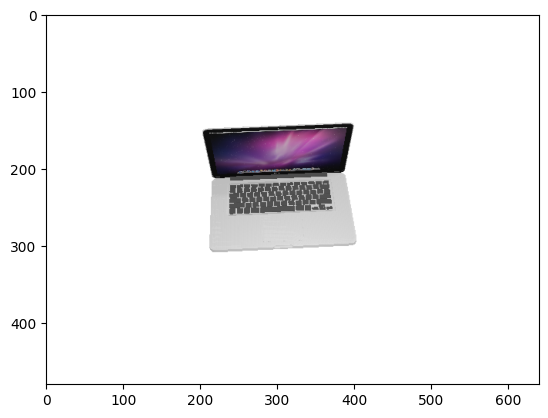

In [10]:
target_img = rgb.view([h, w, 3]).cpu().numpy()
plt.imshow(target_img)

In [11]:
result_img = []

for p in tqdm(result):
    ret_rgb = render_img(model, directions, p, chunk_size=4096*16)
    img = ret_rgb.view([h, w, 3]).cpu().numpy()
    result_img  += [img]

100%|██████████| 30/30 [03:38<00:00,  7.29s/it]


In [12]:
target_pil = Image.fromarray(np.uint8(target_img*255))

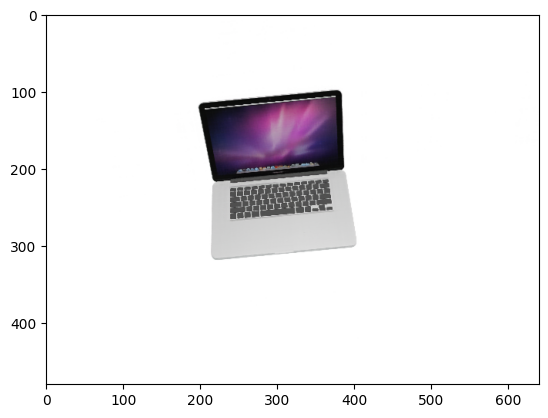

In [13]:
plt.imshow(result_img[2])

In [14]:
pil_imgs = save_images_as_gif(result_img, 1000, './result.gif')

In [15]:
overlay_list = [overlay_images(target_pil, img, 0.5) for img in pil_imgs]
overlay_list[0].save("./result_overlay.gif", save_all=True, append_images=overlay_list[1:], duration=1000, loop=0)

## Test transformation

In [16]:
# load pose
from utils.rotation import *
from utils.viewpoint import change_apply_change_basis
Q = torch.Tensor([0.976296, 0, -0.21644, 0])
ori = torch.Tensor([ 0.24714715,  0.        , -0.00770604])
pose_file = './draft/inerf_pose.json'
with open(pose_file, 'r') as f:
    pose_meta = json.load(f)

v0 = torch.Tensor(np.array(pose_meta['view_0']))
v1 = torch.Tensor(np.array(pose_meta['view_1']))

pose_0 = view2pose_torch(v0)

translation_matrix = torch.eye(4)
translation_matrix[:3, 3] = ori.view([3])
translation_matrix = translation_matrix.to(pose_0)
rotation_matrix = torch.eye(4)
rotation_matrix[:3, :3] = R_from_quaternions(Q)
rotation_matrix = rotation_matrix.to(pose_0)
E2 = change_apply_change_basis_torch(pose_0, rotation_matrix, translation_matrix)
E2_np = change_apply_change_basis(pose_0.numpy(), rotation_matrix.numpy(), translation_matrix.numpy())
view_1 = pose2view_torch(E2)

In [17]:
view_1

tensor([[-0.7332, -0.5087, -0.4512, -2.2363],
        [-0.5878,  0.1405,  0.7967,  3.9836],
        [-0.3419,  0.8494, -0.4020, -2.1152],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [18]:
import torch.nn.functional as F
def quaternion_to_rotation_matrix(quaternion):
    """
    Convert a quaternion to a 3x3 rotation matrix.
    
    Args:
        quaternion (torch.Tensor): A tensor of shape (batch_size, 4) containing quaternions.

    Returns:
        torch.Tensor: A tensor of shape (batch_size, 3, 3) containing rotation matrices.
    """
    # Normalize the quaternion
    quaternions = F.normalize(quaternion, p=2., dim=0)

    # Extract quaternion components
    w, x, y, z = torch.unbind(quaternions, dim=-1)

    # Calculate rotation matrix elements
    xx = x * x
    xy = x * y
    xz = x * z
    xw = x * w
    yy = y * y
    yz = y * z
    yw = y * w
    zz = z * z
    zw = z * w

    # Construct the rotation matrix
    rotation_matrix = torch.stack([
        1 - 2 * (yy + zz),  2 * (xy - zw),      2 * (xz + yw),
        2 * (xy + zw),      1 - 2 * (xx + zz),  2 * (yz - xw),
        2 * (xz - yw),      2 * (yz + xw),      1 - 2 * (xx + yy)
    ], dim=0).view(-1, 3, 3)

    return rotation_matrix

In [19]:
rotation_matrix

tensor([[ 0.9063, -0.0000, -0.4226,  0.0000],
        [ 0.0000,  1.0000, -0.0000,  0.0000],
        [ 0.4226,  0.0000,  0.9063,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [20]:
quaternion_to_rotation_matrix(Q)

tensor([[[ 0.9063, -0.0000, -0.4226],
         [ 0.0000,  1.0000, -0.0000],
         [ 0.4226,  0.0000,  0.9063]]])

In [21]:
E2

tensor([[ 0.4512,  0.7332, -0.5087, -2.2363],
        [-0.7967,  0.5878,  0.1405,  3.9836],
        [ 0.4020,  0.3419,  0.8494, -2.1152],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [22]:
pose_0

tensor([[ 5.7886e-01,  8.0902e-01, -1.0207e-01, -2.8943e+00],
        [-7.9673e-01,  5.8779e-01,  1.4048e-01,  3.9836e+00],
        [ 1.7365e-01, -2.9802e-08,  9.8481e-01, -8.6824e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [23]:
view_1

tensor([[-0.7332, -0.5087, -0.4512, -2.2363],
        [-0.5878,  0.1405,  0.7967,  3.9836],
        [-0.3419,  0.8494, -0.4020, -2.1152],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [24]:
p0 = view2pose_torch(v0)
p0

tensor([[ 5.7886e-01,  8.0902e-01, -1.0207e-01, -2.8943e+00],
        [-7.9673e-01,  5.8779e-01,  1.4048e-01,  3.9836e+00],
        [ 1.7365e-01, -2.9802e-08,  9.8481e-01, -8.6824e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [25]:
column_swap = np.array([
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]
    ])

In [26]:
column_swap = np.array([
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]
    ])